In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Run the following command to disable GPU
# tf.config.set_visible_devices([], 'GPU')

In [2]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns

from utils.plot import *

In [3]:
# Note that we load the model without any fully connected layers,
# since we will not use this model as a classifier in this notebook.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(include_top=False, input_shape=(224, 224, 3))

2022-09-18 02:00:57.785515: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 02:00:57.807915: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


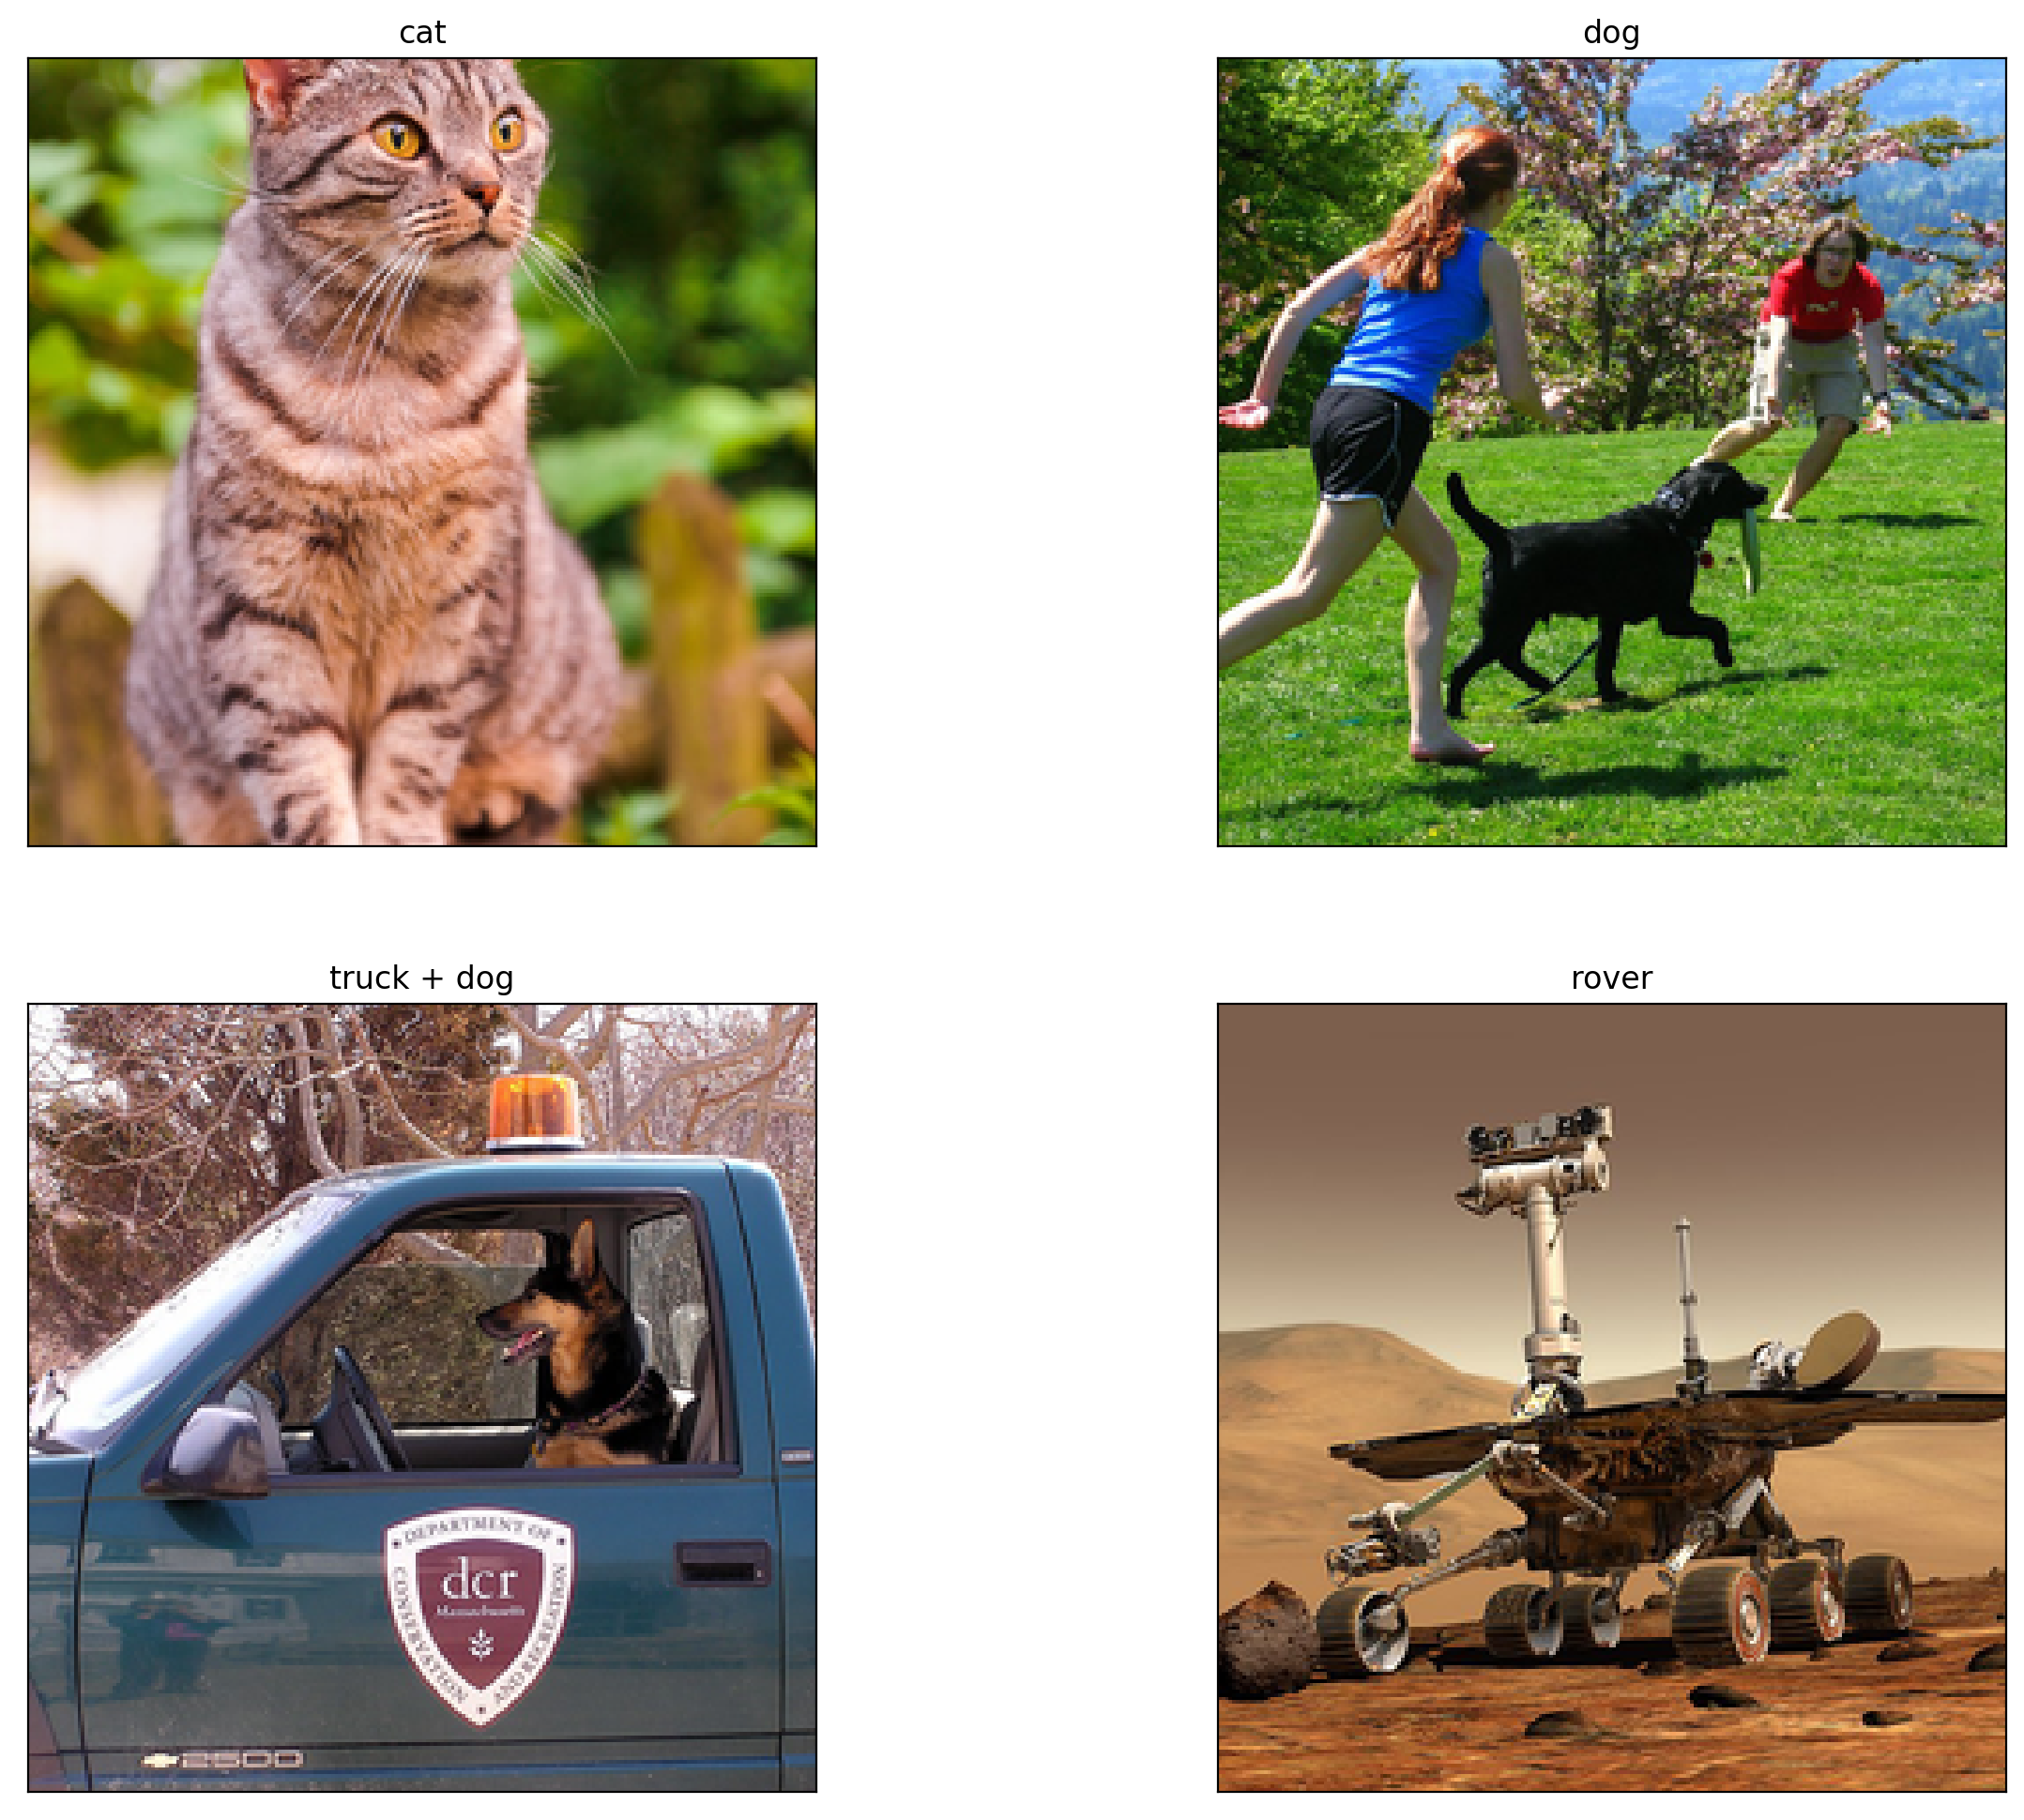

In [4]:
# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()

# Cropped and/or resized into ImageNet shape 224x244x3 array of type uint8 [0, 255]
images_resized = {name: crop_and_resize_for_imagenet(image) for name, image in images_raw.items()}

plot_images_grid(images_resized)

In [5]:
# In order to visualize the first layer's kernels directly,
# we can look at the list weights and choose the first convolution.
# There are two ways to find the right variable:
# 1. By looking at its name. Larger numbers typically correspond to deeper layers.
# 2. By looking at its input channels. The first layer has 3 input channels.
variables = {w.name: w for w in model.weights}
{name: v.shape for name, v in variables.items()}

{'block1_conv1/kernel:0': TensorShape([3, 3, 3, 64]),
 'block1_conv1/bias:0': TensorShape([64]),
 'block1_conv2/kernel:0': TensorShape([3, 3, 64, 64]),
 'block1_conv2/bias:0': TensorShape([64]),
 'block2_conv1/kernel:0': TensorShape([3, 3, 64, 128]),
 'block2_conv1/bias:0': TensorShape([128]),
 'block2_conv2/kernel:0': TensorShape([3, 3, 128, 128]),
 'block2_conv2/bias:0': TensorShape([128]),
 'block3_conv1/kernel:0': TensorShape([3, 3, 128, 256]),
 'block3_conv1/bias:0': TensorShape([256]),
 'block3_conv2/kernel:0': TensorShape([3, 3, 256, 256]),
 'block3_conv2/bias:0': TensorShape([256]),
 'block3_conv3/kernel:0': TensorShape([3, 3, 256, 256]),
 'block3_conv3/bias:0': TensorShape([256]),
 'block4_conv1/kernel:0': TensorShape([3, 3, 256, 512]),
 'block4_conv1/bias:0': TensorShape([512]),
 'block4_conv2/kernel:0': TensorShape([3, 3, 512, 512]),
 'block4_conv2/bias:0': TensorShape([512]),
 'block4_conv3/kernel:0': TensorShape([3, 3, 512, 512]),
 'block4_conv3/bias:0': TensorShape([512])

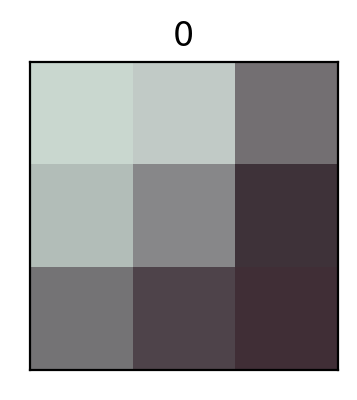

In [6]:
# First, we need to extract the variable's current state
# from Tensorflow graph. Note that we need to use the same
# session as created by Keras, because it's the only session
# where the model's variables are initialized to pre-trained values.
kernel = variables['block1_conv1/kernel:0']

# plot_conv_kernel is a helper function that plots kernels as images.
# See utils.py for details.
plot_conv_kernel(kernel[:, :, :, 0])

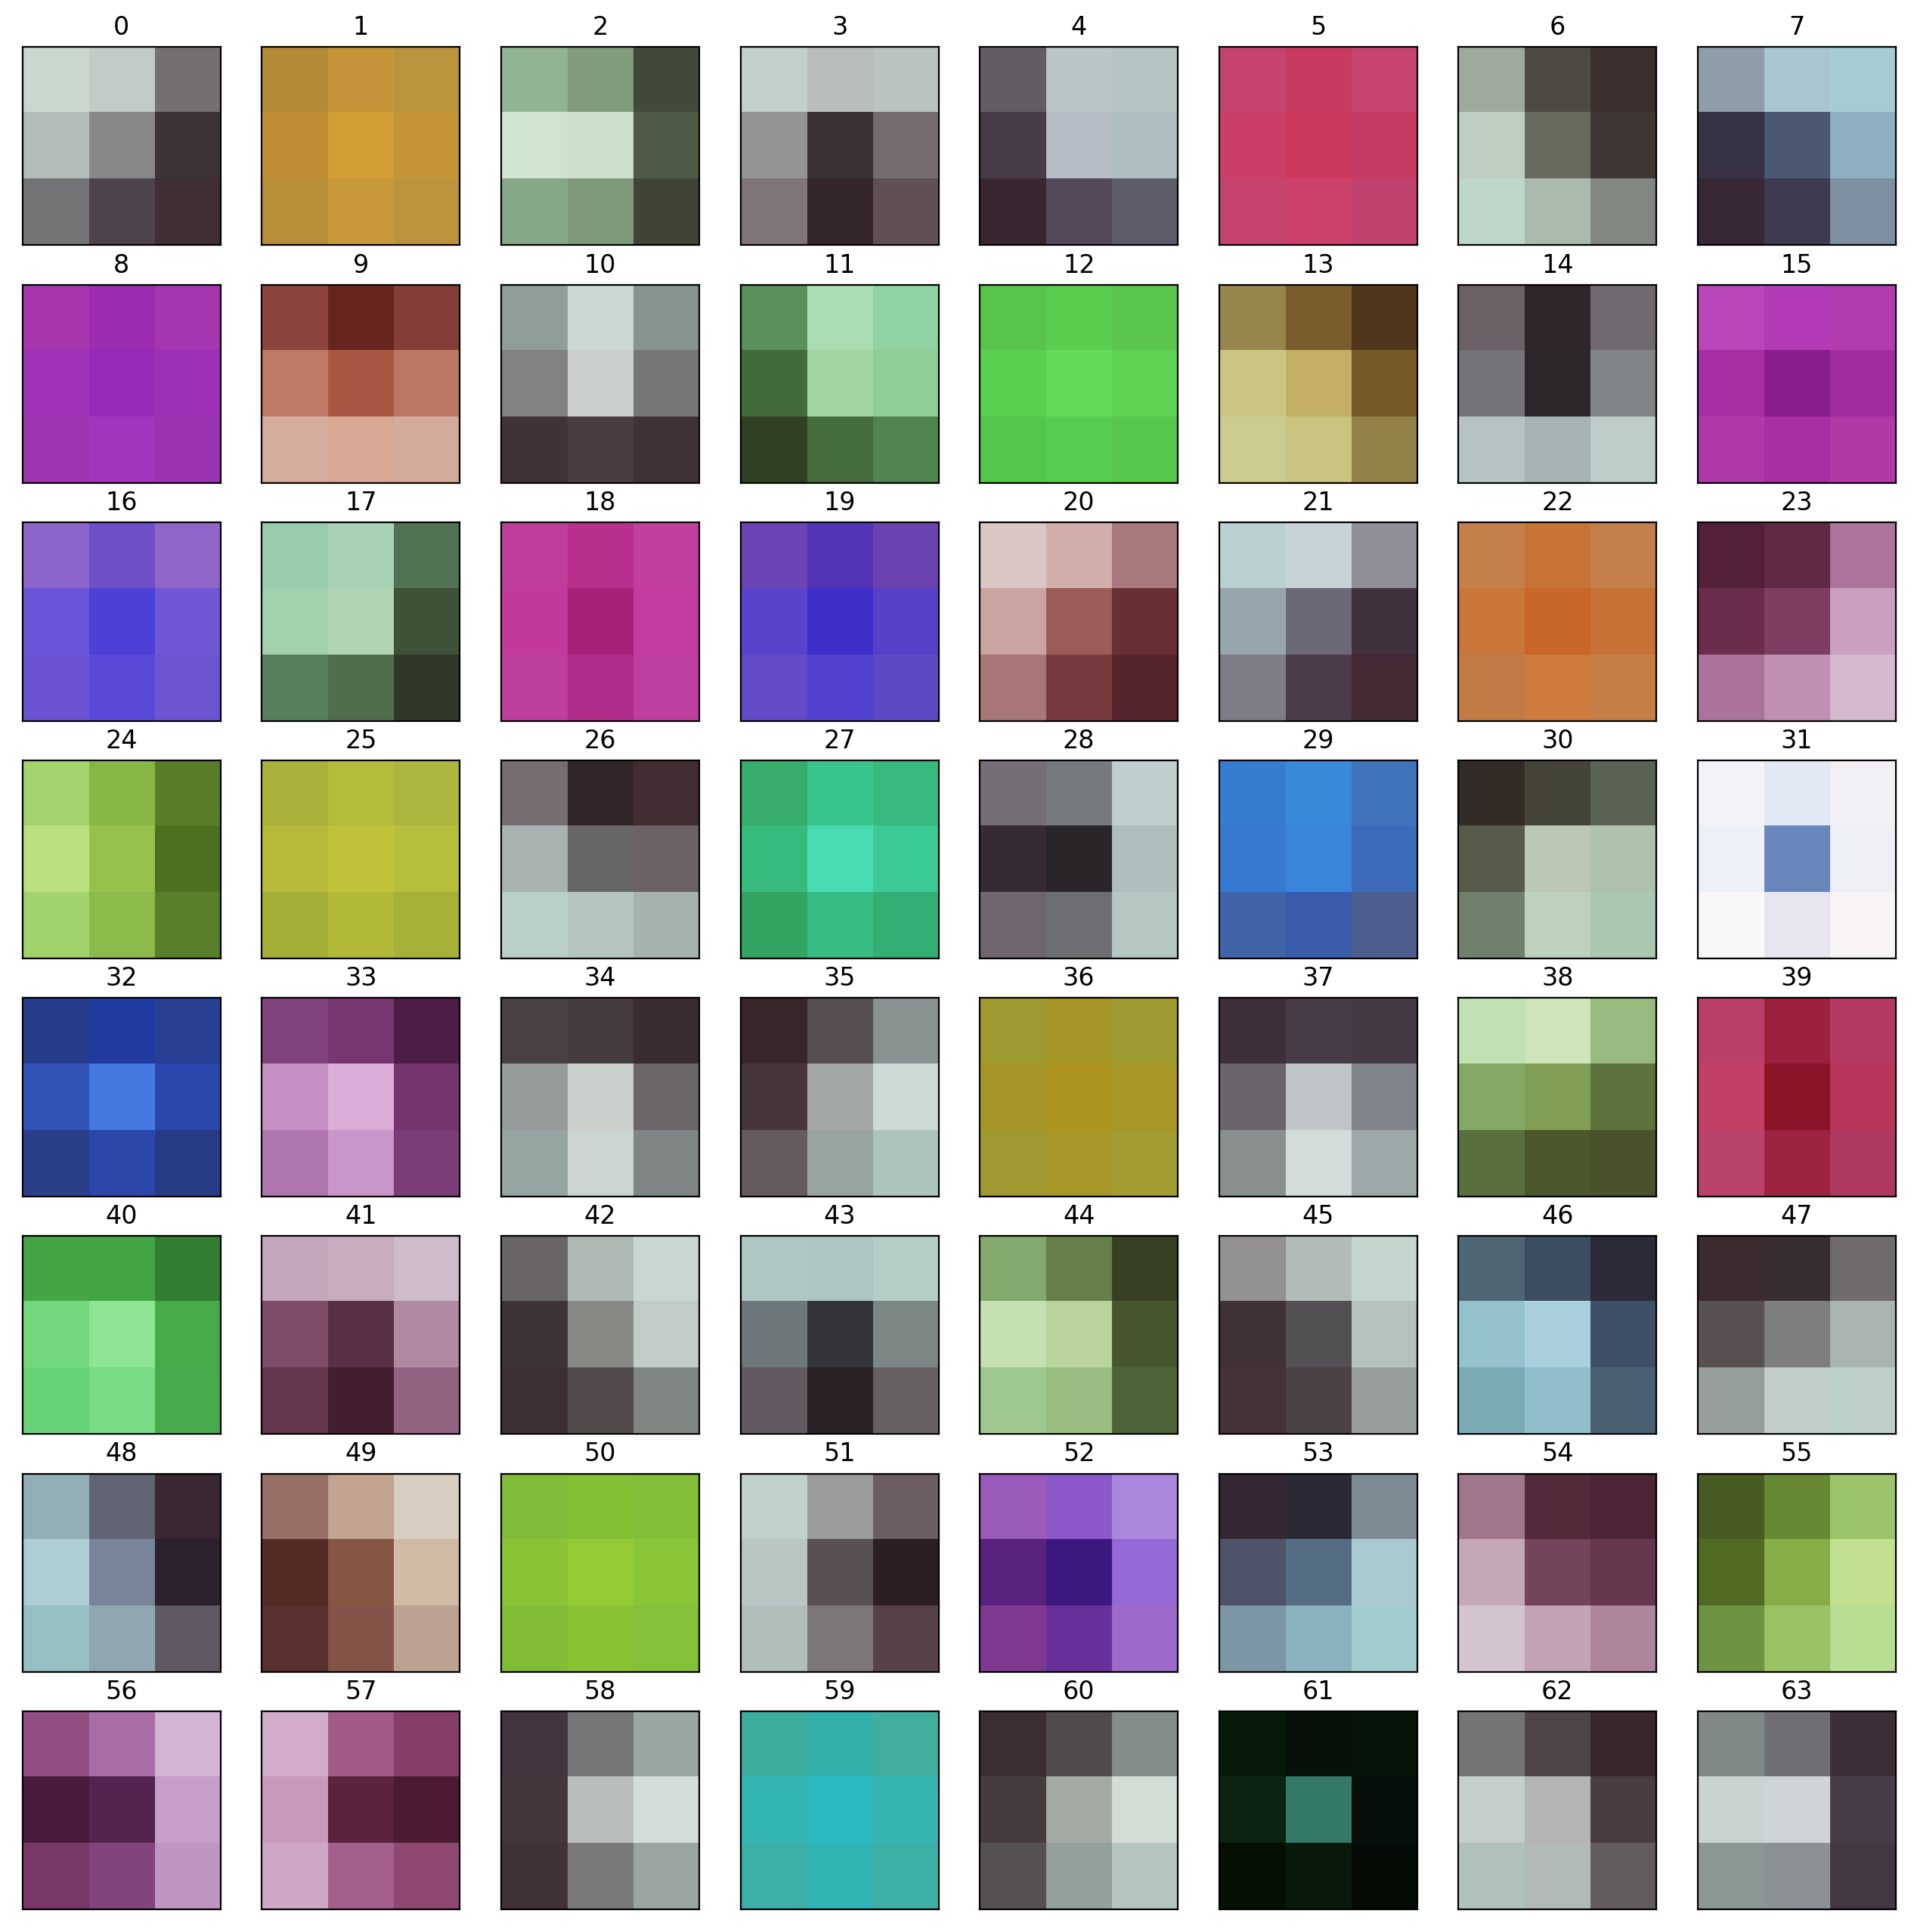

In [7]:
# We can also plot all output channels at once.
plot_conv_kernel(kernel)

In [8]:
# Extract layer information from the model.
layers_by_name = {l.name: l for l in model.layers}
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
target_layer = layers_by_name['block5_conv2']
target_layer_model = Model(inputs=model.inputs, outputs=target_layer.output)

activation_volume_tn = target_layer.output
activation_volume_tn.shape

TensorShape([None, 14, 14, 512])

(1, 224, 224, 3)

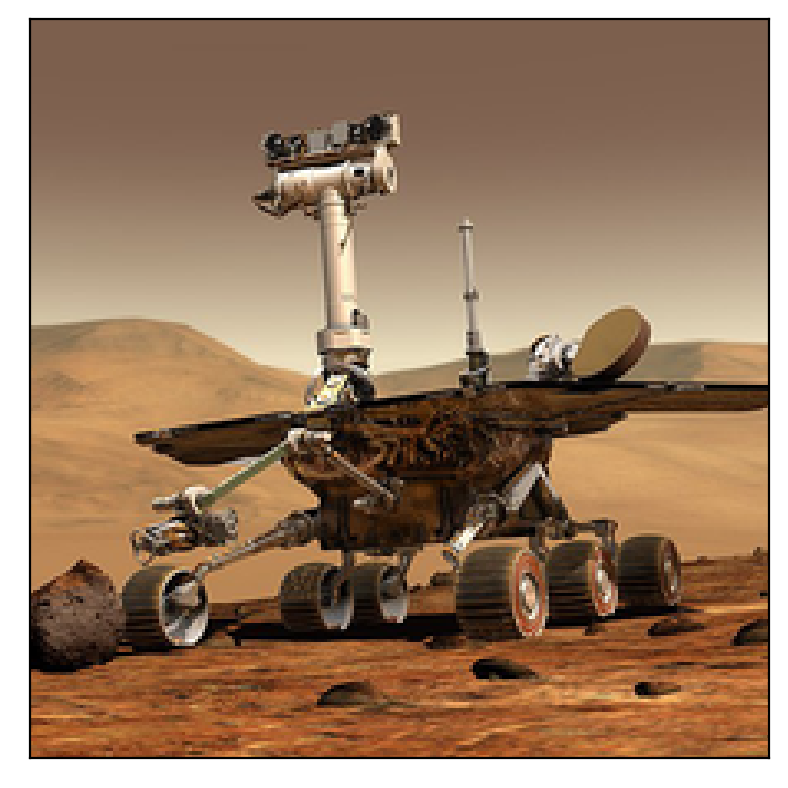

In [10]:
# We will feed this image through the network.
image_start = images_resized['rover']

# The model expects a batch of images, so we need
# to create one more dimension, even though we only 
# have one image the batch.
image_start = np.expand_dims(images_resized['rover'], 0)

plot_image(image_start[0])

image_start.shape

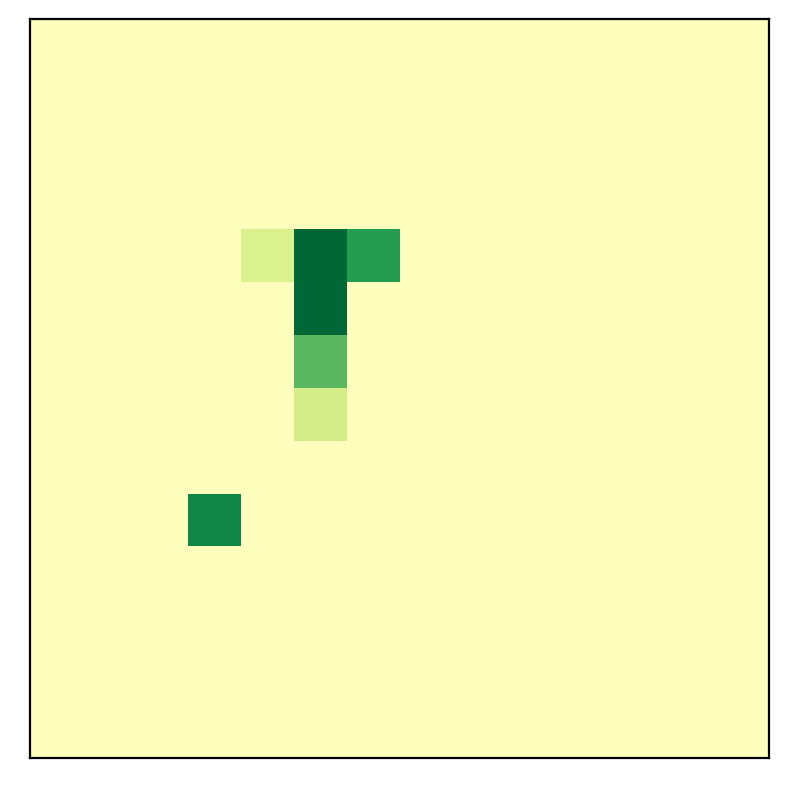

In [11]:
# plot_activation_map is a helper function that
# rescales the map to have std = 1, and applies sigmoid.
# See utils.py for details.

activation_channel = 42
activation_volume = target_layer_model(image_start)[0]
plot_activation_map(activation_volume[:, :, activation_channel].numpy())

In [12]:
# plot_activation_volume is a helper function that
# creates a grid of activation maps from 3-dimensional array.
# Note that it might not plot every channel, because
# the size of the grid is controlled by side parameter,
# and not by the activation volume's depth.
# See utils.py for details.
plot_activation_volume(activation_volume.numpy(), side=16)

In [13]:
# Another method to visualize a deep convolutional layer is
# to search for an image that maximizes its activation.

# Here are the necessary steps:
# 1. Select an activation map
# 2. Calculate its avarage across the spatial dimensions
# 3. Calculate the gradients of the average activation with respect to the input image
# 4. Make a step towards the higher activation
# 5. Clip the image to be within [0, 255] range.
# 6. Repeat steps 2-5 for X iterations

# Here is the function performing steps 1-5:
def image_update_step(
    model: Model, 
    activation_channel: int,
    image_np: np.ndarray,
    learning_rate: float
) -> dict:

    image_tn = tf.constant(image_np, dtype='float32')

    with tf.GradientTape() as tape:
        tape.watch(image_tn)

        activation_volume_tn = model(image_tn)
        activation_map_tn = activation_volume_tn[0, :, :, activation_channel]

        # Note that the cost is the negative of the average, 
        # since we want to maximize the average activation,
        # while decreasing the cost.
        cost_tn = -tf.reduce_mean(activation_map_tn)

        gradient_tn = tape.gradient(cost_tn, image_tn)

        new_image_tn = image_tn - learning_rate * gradient_tn
        new_image_tn = tf.clip_by_value(new_image_tn, 0, 255)
        
    return {
        'activation': activation_map_tn.numpy(),
        'cost': cost_tn.numpy(),
        'gradient': gradient_tn.numpy(),
        'image_new': new_image_tn.numpy()
    }

In [14]:
# Finally, let's run the learning process for 
# X iterations, while collecting the following
# values at each iteration step:
# 1. gradient
# 2. cost value
# 3. activation map
# 4. current image
    
def optimize(
    model: Model, 
    image: Image, 
    activation_channel: int, 
    learning_rate: float,
    iterations: int
) -> dict:
    
    gradients = []
    learning_curve = []
    activations = []
    images = []

    image_current = image

    for i in range(iterations):
        # Save the current image
        images.append(image_current[0].astype(int))

        # Calculate the relevant tensors.
        tensors = image_update_step(model, activation_channel, image_current, learning_rate)

        # Save the values for analysis
        gradients.append(tensors['gradient'])
        learning_curve.append(tensors['cost'])
        activations.append(tensors['activation'])

        # Update the current image for
        # next iteration step.
        image_current = tensors['image_new']
        
    return {
        'gradients': gradients,
        'learning_curve': learning_curve,
        'activations': activations,
        'images': images
    }

In [ ]:
%%time

training_result = optimize(
    target_layer_model, 
    image_start, 
    activation_channel=42,
    learning_rate=10000,
    iterations=50
)
locals().update(training_result)

# Once the learning is finished, plot the learning curve.
sns.lineplot(x=range(len(learning_curve)), y=learning_curve)

In [ ]:
plt.figure(figsize=[10, 10])

plt.subplot(2, 2, 1)
plt.title('Pre-training Activation')
plot_activation_map(activations[0])

plt.subplot(2, 2, 2)
plt.title('Post-training Activation')
plot_activation_map(activations[-1])

plt.subplot(2, 2, 3)
plt.title('Pre-training Image')
plot_image(images[0])

plt.subplot(2, 2, 4)
plt.title('Post-training Image')
plot_image(images[-1])

In [ ]:
nrows = 3
ncols = 3
plt.figure(figsize=[5 * ncols, 5 * nrows])
idxs = np.linspace(0, len(images)-1, nrows*ncols)
idxs = idxs.round().astype(int)

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plot_image(images[idx])
    plt.title(f'Updated Image (Iteration = {idx})')

In [ ]:
# This code cells saves the updated image
# after each iteration to a local folder.
# Use gif.sh script to animate the images.

from PIL import Image
import os
import subprocess

previous_dreams = [
    int(n.split('dream')[1]) for n in os.listdir('.') 
    if n.startswith('dream')
]

if len(previous_dreams) > 0:
    next_dream = max(previous_dreams) + 1
else:
    next_dream = 0

folder = f'dream{next_dream}'
subprocess.run(['mkdir', '-p', folder], check=True)
for idx, image in enumerate(images):
    Image.fromarray(image.astype('uint8')).save(f'{folder}/{idx}.png')

subprocess.run(['../gif.sh', folder], check=True)
print(f'The animation has been saved to {folder}/output.gif')

In [ ]:
%%html
<img src="./vgg_dream_rover.gif">

In [ ]:
result_by_channel = {
    c: optimize(
        target_layer_model, 
        image_start, 
        activation_channel=c,     
        learning_rate=10000, 
        iterations=50
    )
    for c in [1, 16, 32, 42, 64, 128, 256, 300, 500]
}

In [ ]:
nrows = 3
ncols = 3
plt.figure(figsize=[5 * ncols, 5 * nrows])

for i, c in enumerate(result_by_channel.keys()):
    plt.subplot(nrows, ncols, i+1)
    plot_image(result_by_channel[c]['images'][-1])
    plt.title(f'Optimized Channel = {c}')

In [ ]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(activations)-1, nrows*ncols)
idxs = idxs.round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plot_activation_map(activations[idx])
    plt.title(f'Activation Map (Iteration = {idx})')

In [ ]:
# First and last activation map average
activations[0].mean(), activations[-1].mean()

In [ ]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(gradients)-1, nrows*ncols)
idxs = idxs.round().astype(int)

plt.figure(figsize=[5 * ncols, 5 * nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    grad = gradients[idx][0]
    plot_gradient(grad)
    plt.title(f'Activation Gradient (Iteration = {idx})')

In [ ]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(images)-1, nrows*ncols)
idxs = idxs.round().astype(int)

plt.figure(figsize=[6*ncols, 6*nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Distribution of Image Pixels (Iteration = {idx})')
    sns.histplot(images[idx].reshape(-1))

In [ ]:
nrows = 3
ncols = 3
idxs = np.linspace(0, len(gradients)-1, ncols*nrows)
idxs = idxs.round().astype(int)

plt.figure(figsize=[6*ncols, 6*nrows])

for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Distribution of Gradients (Iteration = {idx})')
    sns.histplot(gradients[idx].reshape(-1))